  x        u(x)           estimated error
 -1.00       0.00000000        0.0e+00
 -0.80      -0.05955510        8.6e-10
 -0.60      -0.09636217        3.5e-10
 -0.40      -0.09636217        3.5e-10
 -0.20      -0.05955510        8.6e-10
  0.00       0.00000000        6.5e-27
  0.20       0.05955510        8.6e-10
  0.40       0.09636217        3.5e-10
  0.60       0.09636217        3.5e-10
  0.80       0.05955510        8.6e-10
  1.00       0.00000000        0.0e+00


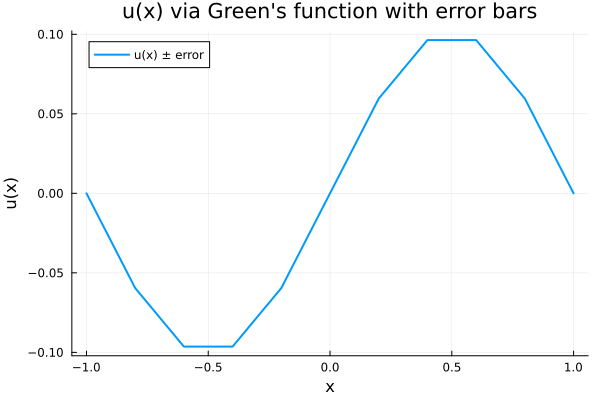

In [2]:
using QuadGK
using Plots
using Printf

# Define the source function f(y)
f(y) = sin(pi * y)

# Define the Green's function kernel k(x, y)
function k(x, y)
    if x < y
        return 0.5 * (1 - y) * (x + 1)
    else
        return 0.5 * (1 + y) * (1 - x)
    end
end

# Compute u(x) = ∫ k(x, y) f(y) dy with error estimate
function u_and_error(x)
    integrand(y) = k(x, y) * f(y)
    val, err = quadgk(integrand, -1.0, 1.0)
    return val, err
end

# Sample x and collect values
x_vals = -1:0.2:1  
u_vals = Float64[]
u_errs = Float64[]

println("  x        u(x)           estimated error")
println("==========================================")
for x in x_vals
    val, err = u_and_error(x)
    push!(u_vals, val)
    push!(u_errs, err)
    @printf("%6.2f   %14.8f   %12.1e\n", x, val, err)
end

# Optional: plot with error ribbon
plot(x_vals, u_vals,
     ribbon = u_errs,
     label = "u(x) ± error",
     xlabel = "x",
     ylabel = "u(x)",
     title = "u(x) via Green's function with error bars",
     lw = 2)

In [3]:
u_and_error(0.1)

(0.03130996766023503, 1.1294772079694249e-10)

In [4]:
f(0.1)

0.3090169943749474

In [5]:
using LinearAlgebra
using Plots

# Define the target function
A(x, y) = cos(x * sin(y))

A (generic function with 1 method)

In [6]:
n = 5 # number of points chosen

# Create a grid of points
x_vals = range(-1, 1, length=n)
y_vals = range(-1, 1, length=n)

points = [(x, y) for x in x_vals, y in y_vals]
points = vec(points)  # flatten 2D to 1D vector of tuples

N = length(points)

25

In [ ]:
# Compute a two dimensional Vandermonde matrix for this system

V_x = x_vals .^ (0:n-1)'
V_y = y_vals .^ (0:n-1)'

V = kron(V_y, V_x)
V

25×36 Matrix{Float64}:
 1.0  -1.0  1.0   -1.0    1.0     -1.0      …  -1.0          1.0
 1.0  -0.5  0.25  -0.125  0.0625  -0.03125     -0.0625       0.03125
 1.0   0.0  0.0    0.0    0.0      0.0         -0.0         -0.0
 1.0   0.5  0.25   0.125  0.0625   0.03125     -0.0625      -0.03125
 1.0   1.0  1.0    1.0    1.0      1.0         -1.0         -1.0
 1.0  -1.0  1.0   -1.0    1.0     -1.0      …  -0.03125      0.03125
 1.0  -0.5  0.25  -0.125  0.0625  -0.03125     -0.00195312   0.000976562
 1.0   0.0  0.0    0.0    0.0      0.0         -0.0         -0.0
 1.0   0.5  0.25   0.125  0.0625   0.03125     -0.00195312  -0.000976562
 1.0   1.0  1.0    1.0    1.0      1.0         -0.03125     -0.03125
 ⋮                                 ⋮        ⋱                ⋮
 1.0  -0.5  0.25  -0.125  0.0625  -0.03125      0.00195312  -0.000976562
 1.0   0.0  0.0    0.0    0.0      0.0          0.0          0.0
 1.0   0.5  0.25   0.125  0.0625   0.03125      0.00195312   0.000976562
 1.0   1.0  1.0    1.

In [8]:
# Evaluate function at grid points
b = [A(x, y) for (x, y) in points]

# Solve V * c = b
c = V \ b

36-element Vector{Float64}:
  0.9999999999999998
  2.4650973846989263e-17
 -3.613268917714648e-17
  6.384948852790497e-17
  2.956991264235758e-17
 -8.71926857242695e-17
  1.9607408628814224e-17
  8.997870610502465e-18
  2.464750998112573e-16
 -6.810126992447754e-16
  ⋮
 -6.45085690337918e-16
  0.015414670721661222
  5.816011345865701e-16
  8.406739246736395e-17
 -3.895769905797666e-16
  4.0241461872856527e-17
 -9.410734096354104e-17
  3.8868872101657196e-16
 -1.9618369881051497e-17

In [9]:
function monomial_powers_2d(degree::Int)
        powers = []
        for i in 0:degree
            for j in 0:(degree - i)
                push!(powers, (i, j))
            end
        end
        return powers
    end

function evaluate_poly(x, y, c, powers)
    result = 0.0
    for (coeff, (i, j)) in zip(c, powers)
        result += coeff * x^i * y^j
    end
    return result
end

evaluate_poly (generic function with 1 method)

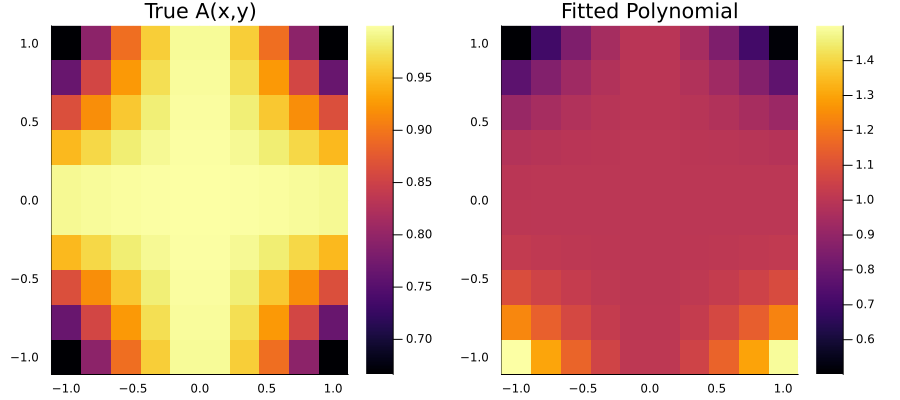

In [10]:
x_grid = range(-1,1,10)
y_grid = range(-1,1,10)
powers = monomial_powers_2d(n)


Z_true = [A(x, y) for x in x_grid, y in y_grid]
Z_fit  = [evaluate_poly(x, y, c, powers) for x in x_grid, y in y_grid]

plot(
    heatmap(x_grid, y_grid, Z_true', title="True A(x,y)"),
    heatmap(x_grid, y_grid, Z_fit', title="Fitted Polynomial"),
    layout=(1, 2), size=(900, 400)
)

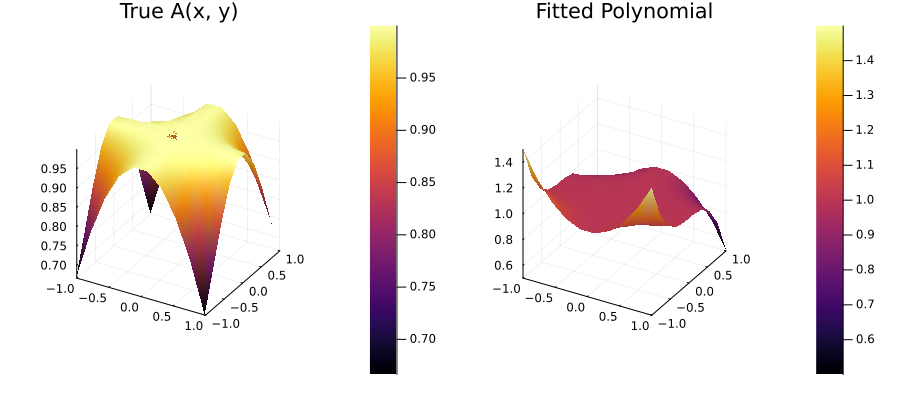

In [11]:
# Surface plot of both functions side by side
plot(
    surface(x_grid, y_grid, Z_true', title="True A(x, y)"),
    surface(x_grid, y_grid, Z_fit', title="Fitted Polynomial"),
    layout=(1, 2), size=(900, 400)
)

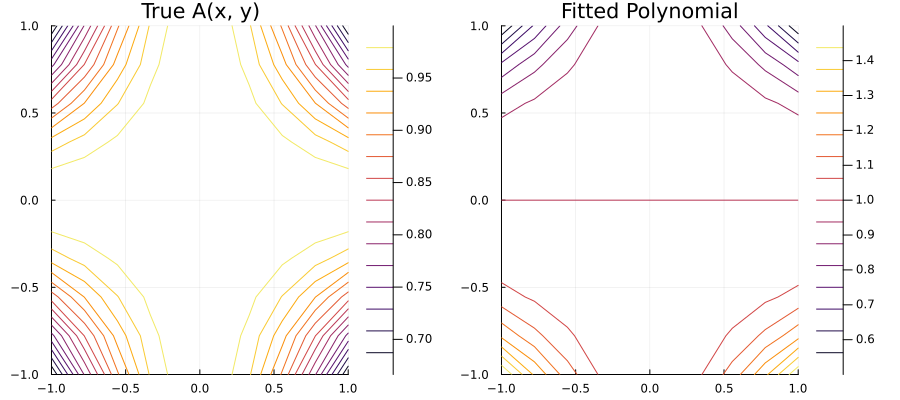

In [12]:
# Contour plots (top-down view)
plot(
    contour(x_grid, y_grid, Z_true', title="True A(x, y)"),
    contour(x_grid, y_grid, Z_fit', title="Fitted Polynomial"),
    layout=(1, 2), size=(900, 400)
)

Least Squares Regression

In [ ]:
using Plots
x_grid = range(-1,1,100)
y_grid = range(-1,1,100)
least_squares_points = [(x,y) for x in x_grid, y in y_grid]
b = [A(x, y) for (x, y) in vec(least_squares_points)]
V_y = y_grid .^ (0:n)'
V_x = x_grid .^ (0:n)'
V = kron(V_y, V_x)
powers = 10
c = V \ b
Z_true = [A(x, y) for x in x_grid, y in y_grid]
plot(
    surface(x_grid, y_grid, Z_true', title="True A(x, y)"),
    surface(x_grid, y_grid, V*c, title = "Least Squares Approximation"),
    layout=(1, 2), size=(900, 400)
    )

Using Finite Differences to Calculate $K(x,y)$, a numerical approximation of the Green's Function.

$\frac{\partial^2}{\partial x^2} K(x,y) + x^2K(x,y) = \delta_y$

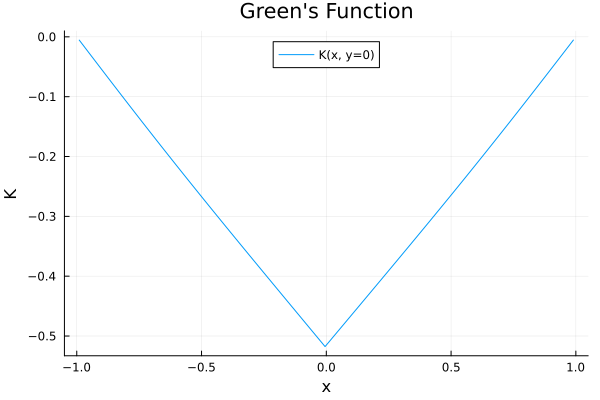

In [14]:
using LinearAlgebra
using Plots

n = 200
x = range(-1, 1; length=n+2)
a = -1
b = 1
h = (b - a) / (n + 1)
x_inner = x[2:end-1]    # n interior points

# Define the potential V(x) = x^2
V = x_inner.^2

# Construct the matrix A
main_diag = -2 / h^2 .+ V
off_diag = 1 / h^2 * ones(n - 1)
A_mat = Tridiagonal(off_diag, main_diag, off_diag)

# Right-hand side: approximate δ(x - y) at y = 0
f_2 = zeros(n)
mid = div(n, 2)  # middle index
f_2[mid] = 1 / h  # spike approximating δ

# y can be changed here with a little bit more thought

K = A_mat \ f_2

plot(x_inner, K, label = "K(x, y=0)", xlabel = "x", ylabel = "K", title = "Green's Function", legend = :top)